In [1]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA RTX A6000
Using device: cuda


In [10]:
import os

edf_folder = r"E:\sleep_full_dataset"  # Change this to the correct folder path

# Get all files in the folder
all_files = os.listdir(edf_folder)

# Extract PSG and Hypnogram file lists
psg_files = [f for f in all_files if "-PSG.edf" in f]
hypnogram_files = [f for f in all_files if "-Hypnogram.edf" in f]

# Extract subject IDs using only the first 7 characters (e.g., "SC4022")
psg_subjects = {f[:7]: f for f in psg_files}
hypnogram_subjects = {f[:7]: f for f in hypnogram_files}

# Find matching PSG & Hypnogram pairs
matched_files = []
for subject_id, psg_file in psg_subjects.items():
    if subject_id in hypnogram_subjects:
        matched_files.append((psg_file, hypnogram_subjects[subject_id]))
    else:
        print(f"⚠️ Warning: Hypnogram file not found for {psg_file}")

# Print matched PSG-Hypnogram pairs
for psg, hypnogram in matched_files:
    print(f"✅ Matched: {psg} <-> {hypnogram}")

⚠️ Warning: Hypnogram file not found for SC4801G0-PSG.edf
⚠️ Warning: Hypnogram file not found for SC4802G0-PSG.edf
⚠️ Warning: Hypnogram file not found for SC4812G0-PSG.edf
⚠️ Warning: Hypnogram file not found for ST7021J0-PSG.edf
⚠️ Warning: Hypnogram file not found for ST7071J0-PSG.edf
⚠️ Warning: Hypnogram file not found for ST7092J0-PSG.edf
✅ Matched: SC4092E0-PSG.edf <-> SC4092EC-Hypnogram.edf
✅ Matched: SC4101E0-PSG.edf <-> SC4101EC-Hypnogram.edf
✅ Matched: SC4102E0-PSG.edf <-> SC4102EC-Hypnogram.edf
✅ Matched: SC4111E0-PSG.edf <-> SC4111EC-Hypnogram.edf
✅ Matched: SC4112E0-PSG.edf <-> SC4112EC-Hypnogram.edf
✅ Matched: SC4121E0-PSG.edf <-> SC4121EC-Hypnogram.edf
✅ Matched: SC4122E0-PSG.edf <-> SC4122EV-Hypnogram.edf
✅ Matched: SC4131E0-PSG.edf <-> SC4131EC-Hypnogram.edf
✅ Matched: SC4141E0-PSG.edf <-> SC4141EU-Hypnogram.edf
✅ Matched: SC4142E0-PSG.edf <-> SC4142EU-Hypnogram.edf
✅ Matched: SC4151E0-PSG.edf <-> SC4151EC-Hypnogram.edf
✅ Matched: SC4152E0-PSG.edf <-> SC4152EC-Hypnog

In [9]:
import os
import pyedflib

edf_folder = r"E:\sleep_full_dataset"
invalid_files = []

for file in os.listdir(edf_folder):
    if file.endswith(".edf"):
        file_path = os.path.join(edf_folder, file)
        try:
            edf_reader = pyedflib.EdfReader(file_path)
            edf_reader.close()
        except OSError as e:
            print(f"Invalid EDF file: {file} - Reason: {e}")
            invalid_files.append(file)

print("\nSummary of Invalid EDF files:")
for bad_file in invalid_files:
    print(bad_file)

print(f"\nTotal Invalid EDF files: {len(invalid_files)}")



Summary of Invalid EDF files:

Total Invalid EDF files: 0


In [11]:
import os
import numpy as np
import pyedflib
from tqdm import tqdm

edf_folder = r"E:\sleep_full_dataset"
output_folder = "processed_epochs"
os.makedirs(output_folder, exist_ok=True)

# Required EEG channels
required_channels = ['EEG Fpz-Cz', 'EEG Pz-Oz']

# Function to extract sleep stage labels from hypnogram
def extract_labels(hypnogram_file):
    edf_reader = pyedflib.EdfReader(hypnogram_file)
    annotations = edf_reader.readAnnotations()
    edf_reader.close()
    
    onset_times = annotations[0]  # Start time of annotation
    durations = annotations[1]    # Duration of annotation
    labels = annotations[2]       # Sleep stage labels

    sleep_stages = []
    for onset, duration, label in zip(onset_times, durations, labels):
        epoch_count = int(duration // 30)  # Number of 30-sec epochs
        sleep_stages.extend([label] * epoch_count)

    return np.array(sleep_stages)

# Process each matched PSG-Hypnogram pair
for psg_file, hypnogram_file in tqdm(matched_files, desc="Processing EEG Data"):
    psg_path = os.path.join(edf_folder, psg_file)
    hypnogram_path = os.path.join(edf_folder, hypnogram_file)

    # Load EEG data from PSG file
    edf_reader = pyedflib.EdfReader(psg_path)
    channel_labels = edf_reader.getSignalLabels()

    # Find indices of required channels
    channel_indices = [channel_labels.index(ch) for ch in required_channels if ch in channel_labels]
    if not channel_indices:
        print(f"Skipping {psg_file}: Required EEG channels not found!")
        edf_reader.close()
        continue

    # Extract EEG signals
    eeg_signals = np.array([edf_reader.readSignal(idx) for idx in channel_indices])
    sampling_rate = edf_reader.getSampleFrequencies()[channel_indices[0]]
    edf_reader.close()

    # Calculate number of samples per 30s epoch
    samples_per_epoch = int(sampling_rate * 30)
    num_epochs = eeg_signals.shape[1] // samples_per_epoch  # Number of full epochs

    # Trim EEG signals to full epochs only
    eeg_epochs = eeg_signals[:, :num_epochs * samples_per_epoch].reshape(num_epochs, len(channel_indices), samples_per_epoch)

    # Extract sleep stage labels
    sleep_labels = extract_labels(hypnogram_path)

    # Ensure sleep labels match the number of epochs
    min_epochs = min(num_epochs, len(sleep_labels))
    eeg_epochs = eeg_epochs[:min_epochs]
    sleep_labels = sleep_labels[:min_epochs]

    # Save processed epochs
    save_path = os.path.join(output_folder, psg_file.replace("-PSG.edf", ".npz"))
    np.savez(save_path, eeg=eeg_epochs, labels=sleep_labels, fs=sampling_rate, channels=required_channels)

    print(f"Processed and saved: {psg_file}")

print("✅ EEG epochs successfully processed and saved with corresponding labels.")

Processing EEG Data:   1%|          | 1/142 [00:10<24:37, 10.48s/it]

Processed and saved: SC4092E0-PSG.edf


Processing EEG Data:   1%|▏         | 2/142 [00:20<23:34, 10.10s/it]

Processed and saved: SC4101E0-PSG.edf


Processing EEG Data:   2%|▏         | 3/142 [00:30<23:43, 10.24s/it]

Processed and saved: SC4102E0-PSG.edf


Processing EEG Data:   3%|▎         | 4/142 [00:40<23:01, 10.01s/it]

Processed and saved: SC4111E0-PSG.edf


Processing EEG Data:   4%|▎         | 5/142 [00:50<23:03, 10.10s/it]

Processed and saved: SC4112E0-PSG.edf


Processing EEG Data:   4%|▍         | 6/142 [01:00<23:01, 10.16s/it]

Processed and saved: SC4121E0-PSG.edf


Processing EEG Data:   5%|▍         | 7/142 [01:10<22:19,  9.92s/it]

Processed and saved: SC4122E0-PSG.edf


Processing EEG Data:   6%|▌         | 8/142 [01:20<22:23, 10.03s/it]

Processed and saved: SC4131E0-PSG.edf


Processing EEG Data:   6%|▋         | 9/142 [01:30<22:12, 10.02s/it]

Processed and saved: SC4141E0-PSG.edf


Processing EEG Data:   7%|▋         | 10/142 [01:40<22:09, 10.07s/it]

Processed and saved: SC4142E0-PSG.edf


Processing EEG Data:   8%|▊         | 11/142 [01:50<21:42,  9.94s/it]

Processed and saved: SC4151E0-PSG.edf


Processing EEG Data:   8%|▊         | 12/142 [02:00<21:50, 10.08s/it]

Processed and saved: SC4152E0-PSG.edf


Processing EEG Data:   9%|▉         | 13/142 [02:10<21:18,  9.91s/it]

Processed and saved: SC4161E0-PSG.edf


Processing EEG Data:  10%|▉         | 14/142 [02:20<21:12,  9.94s/it]

Processed and saved: SC4162E0-PSG.edf


Processing EEG Data:  11%|█         | 15/142 [02:30<21:04,  9.96s/it]

Processed and saved: SC4171E0-PSG.edf


Processing EEG Data:  11%|█▏        | 16/142 [02:40<20:53,  9.95s/it]

Processed and saved: SC4172E0-PSG.edf


Processing EEG Data:  12%|█▏        | 17/142 [02:50<20:52, 10.02s/it]

Processed and saved: SC4181E0-PSG.edf


Processing EEG Data:  13%|█▎        | 18/142 [03:00<20:55, 10.13s/it]

Processed and saved: SC4182E0-PSG.edf


Processing EEG Data:  13%|█▎        | 19/142 [03:10<20:43, 10.11s/it]

Processed and saved: SC4191E0-PSG.edf


Processing EEG Data:  14%|█▍        | 20/142 [03:20<20:10,  9.92s/it]

Processed and saved: SC4192E0-PSG.edf


Processing EEG Data:  15%|█▍        | 21/142 [03:30<20:09,  9.99s/it]

Processed and saved: SC4201E0-PSG.edf


Processing EEG Data:  15%|█▌        | 22/142 [03:40<19:47,  9.90s/it]

Processed and saved: SC4202E0-PSG.edf


Processing EEG Data:  16%|█▌        | 23/142 [03:50<19:50, 10.01s/it]

Processed and saved: SC4211E0-PSG.edf


Processing EEG Data:  17%|█▋        | 24/142 [04:00<19:36,  9.97s/it]

Processed and saved: SC4212E0-PSG.edf


Processing EEG Data:  18%|█▊        | 25/142 [04:10<19:19,  9.91s/it]

Processed and saved: SC4221E0-PSG.edf


Processing EEG Data:  18%|█▊        | 26/142 [04:20<19:12,  9.94s/it]

Processed and saved: SC4222E0-PSG.edf


Processing EEG Data:  19%|█▉        | 27/142 [04:30<19:02,  9.94s/it]

Processed and saved: SC4231E0-PSG.edf


Processing EEG Data:  20%|█▉        | 28/142 [04:39<18:40,  9.83s/it]

Processed and saved: SC4232E0-PSG.edf


Processing EEG Data:  20%|██        | 29/142 [04:49<18:30,  9.83s/it]

Processed and saved: SC4241E0-PSG.edf


Processing EEG Data:  21%|██        | 30/142 [04:59<18:23,  9.85s/it]

Processed and saved: SC4242E0-PSG.edf


Processing EEG Data:  22%|██▏       | 31/142 [05:09<18:19,  9.90s/it]

Processed and saved: SC4251E0-PSG.edf


Processing EEG Data:  23%|██▎       | 32/142 [05:19<17:58,  9.80s/it]

Processed and saved: SC4252E0-PSG.edf


Processing EEG Data:  23%|██▎       | 33/142 [05:29<18:02,  9.93s/it]

Processed and saved: SC4261F0-PSG.edf


Processing EEG Data:  24%|██▍       | 34/142 [05:39<17:50,  9.91s/it]

Processed and saved: SC4262F0-PSG.edf


Processing EEG Data:  25%|██▍       | 35/142 [05:47<17:04,  9.57s/it]

Processed and saved: SC4271F0-PSG.edf


Processing EEG Data:  25%|██▌       | 36/142 [05:58<17:27,  9.88s/it]

Processed and saved: SC4272F0-PSG.edf


Processing EEG Data:  26%|██▌       | 37/142 [06:08<17:21,  9.92s/it]

Processed and saved: SC4281G0-PSG.edf


Processing EEG Data:  27%|██▋       | 38/142 [06:18<17:25, 10.06s/it]

Processed and saved: SC4282G0-PSG.edf


Processing EEG Data:  27%|██▋       | 39/142 [06:28<17:14, 10.05s/it]

Processed and saved: SC4291G0-PSG.edf


Processing EEG Data:  28%|██▊       | 40/142 [06:38<17:05, 10.06s/it]

Processed and saved: SC4292G0-PSG.edf


Processing EEG Data:  29%|██▉       | 41/142 [06:48<16:45,  9.96s/it]

Processed and saved: SC4311E0-PSG.edf


Processing EEG Data:  30%|██▉       | 42/142 [06:58<16:32,  9.92s/it]

Processed and saved: SC4312E0-PSG.edf


Processing EEG Data:  30%|███       | 43/142 [07:08<16:22,  9.92s/it]

Processed and saved: SC4321E0-PSG.edf


Processing EEG Data:  31%|███       | 44/142 [07:18<16:17,  9.97s/it]

Processed and saved: SC4331F0-PSG.edf


Processing EEG Data:  32%|███▏      | 45/142 [07:28<16:05,  9.95s/it]

Processed and saved: SC4332F0-PSG.edf


Processing EEG Data:  32%|███▏      | 46/142 [07:38<15:53,  9.93s/it]

Processed and saved: SC4341F0-PSG.edf


Processing EEG Data:  33%|███▎      | 47/142 [07:48<15:45,  9.96s/it]

Processed and saved: SC4342F0-PSG.edf


Processing EEG Data:  34%|███▍      | 48/142 [07:58<15:30,  9.90s/it]

Processed and saved: SC4351F0-PSG.edf


Processing EEG Data:  35%|███▍      | 49/142 [08:07<14:57,  9.65s/it]

Processed and saved: SC4352F0-PSG.edf


Processing EEG Data:  35%|███▌      | 50/142 [08:12<12:55,  8.43s/it]

Processed and saved: SC4362F0-PSG.edf


Processing EEG Data:  36%|███▌      | 51/142 [08:22<13:33,  8.94s/it]

Processed and saved: SC4371F0-PSG.edf


Processing EEG Data:  37%|███▋      | 52/142 [08:33<13:59,  9.32s/it]

Processed and saved: SC4372F0-PSG.edf


Processing EEG Data:  37%|███▋      | 53/142 [08:42<14:04,  9.49s/it]

Processed and saved: SC4381F0-PSG.edf


Processing EEG Data:  38%|███▊      | 54/142 [08:52<14:07,  9.63s/it]

Processed and saved: SC4382F0-PSG.edf


Processing EEG Data:  39%|███▊      | 55/142 [09:02<13:52,  9.56s/it]

Processed and saved: SC4401E0-PSG.edf


Processing EEG Data:  39%|███▉      | 56/142 [09:12<13:52,  9.69s/it]

Processed and saved: SC4402E0-PSG.edf


Processing EEG Data:  40%|████      | 57/142 [09:22<13:45,  9.71s/it]

Processed and saved: SC4411E0-PSG.edf


Processing EEG Data:  41%|████      | 58/142 [09:32<13:50,  9.89s/it]

Processed and saved: SC4412E0-PSG.edf


Processing EEG Data:  42%|████▏     | 59/142 [09:42<13:41,  9.90s/it]

Processed and saved: SC4421E0-PSG.edf


Processing EEG Data:  42%|████▏     | 60/142 [09:51<13:25,  9.82s/it]

Processed and saved: SC4422E0-PSG.edf


Processing EEG Data:  43%|████▎     | 61/142 [10:02<13:23,  9.92s/it]

Processed and saved: SC4431E0-PSG.edf


Processing EEG Data:  44%|████▎     | 62/142 [10:12<13:15,  9.95s/it]

Processed and saved: SC4432E0-PSG.edf


Processing EEG Data:  44%|████▍     | 63/142 [10:21<12:55,  9.81s/it]

Processed and saved: SC4441E0-PSG.edf


Processing EEG Data:  45%|████▌     | 64/142 [10:31<12:50,  9.88s/it]

Processed and saved: SC4442E0-PSG.edf


Processing EEG Data:  46%|████▌     | 65/142 [10:41<12:44,  9.93s/it]

Processed and saved: SC4451F0-PSG.edf


Processing EEG Data:  46%|████▋     | 66/142 [10:51<12:29,  9.86s/it]

Processed and saved: SC4452F0-PSG.edf


Processing EEG Data:  47%|████▋     | 67/142 [11:01<12:18,  9.85s/it]

Processed and saved: SC4461F0-PSG.edf


Processing EEG Data:  48%|████▊     | 68/142 [11:11<12:20, 10.00s/it]

Processed and saved: SC4462F0-PSG.edf


Processing EEG Data:  49%|████▊     | 69/142 [11:21<12:07,  9.96s/it]

Processed and saved: SC4471F0-PSG.edf


Processing EEG Data:  49%|████▉     | 70/142 [11:31<11:59,  9.99s/it]

Processed and saved: SC4472F0-PSG.edf


Processing EEG Data:  50%|█████     | 71/142 [11:41<11:57, 10.11s/it]

Processed and saved: SC4481F0-PSG.edf


Processing EEG Data:  51%|█████     | 72/142 [11:52<11:54, 10.21s/it]

Processed and saved: SC4482F0-PSG.edf


Processing EEG Data:  51%|█████▏    | 73/142 [12:02<11:43, 10.19s/it]

Processed and saved: SC4491G0-PSG.edf


Processing EEG Data:  52%|█████▏    | 74/142 [12:10<10:43,  9.46s/it]

Processed and saved: SC4492G0-PSG.edf


Processing EEG Data:  53%|█████▎    | 75/142 [12:20<10:49,  9.70s/it]

Processed and saved: SC4501E0-PSG.edf


Processing EEG Data:  54%|█████▎    | 76/142 [12:30<10:46,  9.79s/it]

Processed and saved: SC4502E0-PSG.edf


Processing EEG Data:  54%|█████▍    | 77/142 [12:40<10:35,  9.78s/it]

Processed and saved: SC4511E0-PSG.edf


Processing EEG Data:  55%|█████▍    | 78/142 [12:50<10:29,  9.84s/it]

Processed and saved: SC4512E0-PSG.edf


Processing EEG Data:  56%|█████▌    | 79/142 [13:00<10:24,  9.91s/it]

Processed and saved: SC4522E0-PSG.edf


Processing EEG Data:  56%|█████▋    | 80/142 [13:09<10:04,  9.75s/it]

Processed and saved: SC4531E0-PSG.edf


Processing EEG Data:  57%|█████▋    | 81/142 [13:19<09:57,  9.80s/it]

Processed and saved: SC4532E0-PSG.edf


Processing EEG Data:  58%|█████▊    | 82/142 [13:29<09:49,  9.82s/it]

Processed and saved: SC4541F0-PSG.edf


Processing EEG Data:  58%|█████▊    | 83/142 [13:39<09:37,  9.78s/it]

Processed and saved: SC4542F0-PSG.edf


Processing EEG Data:  59%|█████▉    | 84/142 [13:49<09:32,  9.86s/it]

Processed and saved: SC4551F0-PSG.edf


Processing EEG Data:  60%|█████▉    | 85/142 [13:59<09:28,  9.98s/it]

Processed and saved: SC4552F0-PSG.edf


Processing EEG Data:  61%|██████    | 86/142 [14:09<09:15,  9.93s/it]

Processed and saved: SC4561F0-PSG.edf


Processing EEG Data:  61%|██████▏   | 87/142 [14:19<09:11, 10.02s/it]

Processed and saved: SC4562F0-PSG.edf


Processing EEG Data:  62%|██████▏   | 88/142 [14:29<09:05, 10.10s/it]

Processed and saved: SC4571F0-PSG.edf


Processing EEG Data:  63%|██████▎   | 89/142 [14:40<08:59, 10.17s/it]

Processed and saved: SC4572F0-PSG.edf


Processing EEG Data:  63%|██████▎   | 90/142 [14:50<08:44, 10.09s/it]

Processed and saved: SC4581G0-PSG.edf


Processing EEG Data:  64%|██████▍   | 91/142 [14:59<08:26,  9.94s/it]

Processed and saved: SC4582G0-PSG.edf


Processing EEG Data:  65%|██████▍   | 92/142 [15:10<08:23, 10.08s/it]

Processed and saved: SC4591G0-PSG.edf


Processing EEG Data:  65%|██████▌   | 93/142 [15:17<07:34,  9.27s/it]

Processed and saved: SC4592G0-PSG.edf


Processing EEG Data:  66%|██████▌   | 94/142 [15:27<07:33,  9.45s/it]

Processed and saved: SC4601E0-PSG.edf


Processing EEG Data:  67%|██████▋   | 95/142 [15:37<07:35,  9.68s/it]

Processed and saved: SC4602E0-PSG.edf


Processing EEG Data:  68%|██████▊   | 96/142 [15:47<07:27,  9.73s/it]

Processed and saved: SC4611E0-PSG.edf


Processing EEG Data:  68%|██████▊   | 97/142 [15:57<07:23,  9.85s/it]

Processed and saved: SC4612E0-PSG.edf


Processing EEG Data:  69%|██████▉   | 98/142 [16:06<07:07,  9.73s/it]

Processed and saved: SC4621E0-PSG.edf


Processing EEG Data:  70%|██████▉   | 99/142 [16:17<07:05,  9.90s/it]

Processed and saved: SC4622E0-PSG.edf


Processing EEG Data:  70%|███████   | 100/142 [16:27<06:56,  9.92s/it]

Processed and saved: SC4631E0-PSG.edf


Processing EEG Data:  71%|███████   | 101/142 [16:37<06:50, 10.02s/it]

Processed and saved: SC4632E0-PSG.edf


Processing EEG Data:  72%|███████▏  | 102/142 [16:47<06:39,  9.98s/it]

Processed and saved: SC4641E0-PSG.edf


Processing EEG Data:  73%|███████▎  | 103/142 [16:57<06:34, 10.11s/it]

Processed and saved: SC4651E0-PSG.edf


Processing EEG Data:  73%|███████▎  | 104/142 [17:08<06:25, 10.16s/it]

Processed and saved: SC4652E0-PSG.edf


Processing EEG Data:  74%|███████▍  | 105/142 [17:18<06:14, 10.12s/it]

Processed and saved: SC4661E0-PSG.edf


Processing EEG Data:  75%|███████▍  | 106/142 [17:28<06:05, 10.16s/it]

Processed and saved: SC4662E0-PSG.edf


Processing EEG Data:  75%|███████▌  | 107/142 [17:38<05:54, 10.13s/it]

Processed and saved: SC4671G0-PSG.edf


Processing EEG Data:  76%|███████▌  | 108/142 [17:47<05:36,  9.89s/it]

Processed and saved: SC4672G0-PSG.edf


Processing EEG Data:  77%|███████▋  | 109/142 [17:57<05:25,  9.86s/it]

Processed and saved: SC4701E0-PSG.edf


Processing EEG Data:  77%|███████▋  | 110/142 [18:06<05:12,  9.75s/it]

Processed and saved: SC4702E0-PSG.edf


Processing EEG Data:  78%|███████▊  | 111/142 [18:16<05:03,  9.79s/it]

Processed and saved: SC4711E0-PSG.edf


Processing EEG Data:  79%|███████▉  | 112/142 [18:27<04:57,  9.91s/it]

Processed and saved: SC4712E0-PSG.edf


Processing EEG Data:  80%|███████▉  | 113/142 [18:35<04:35,  9.50s/it]

Processed and saved: SC4721E0-PSG.edf


Processing EEG Data:  80%|████████  | 114/142 [18:45<04:30,  9.66s/it]

Processed and saved: SC4722E0-PSG.edf


Processing EEG Data:  81%|████████  | 115/142 [18:55<04:25,  9.82s/it]

Processed and saved: SC4731E0-PSG.edf


Processing EEG Data:  82%|████████▏ | 116/142 [19:04<04:09,  9.61s/it]

Processed and saved: SC4732E0-PSG.edf


Processing EEG Data:  82%|████████▏ | 117/142 [19:14<04:01,  9.65s/it]

Processed and saved: SC4751E0-PSG.edf


Processing EEG Data:  83%|████████▎ | 118/142 [19:23<03:44,  9.37s/it]

Processed and saved: SC4811G0-PSG.edf


Processing EEG Data:  84%|████████▍ | 119/142 [19:33<03:38,  9.51s/it]

Processed and saved: SC4821G0-PSG.edf


Processing EEG Data:  85%|████████▍ | 120/142 [19:43<03:33,  9.71s/it]

Processed and saved: SC4822G0-PSG.edf


Processing EEG Data:  85%|████████▌ | 121/142 [19:50<03:09,  9.01s/it]

Processed and saved: ST7012J0-PSG.edf


Processing EEG Data:  86%|████████▌ | 122/142 [19:58<02:49,  8.50s/it]

Processed and saved: ST7022J0-PSG.edf


Processing EEG Data:  87%|████████▋ | 123/142 [20:05<02:34,  8.14s/it]

Processed and saved: ST7041J0-PSG.edf


Processing EEG Data:  87%|████████▋ | 124/142 [20:13<02:26,  8.13s/it]

Processed and saved: ST7042J0-PSG.edf


Processing EEG Data:  88%|████████▊ | 125/142 [20:21<02:15,  7.97s/it]

Processed and saved: ST7051J0-PSG.edf


Processing EEG Data:  89%|████████▊ | 126/142 [20:28<02:06,  7.89s/it]

Processed and saved: ST7052J0-PSG.edf


Processing EEG Data:  89%|████████▉ | 127/142 [20:36<01:57,  7.80s/it]

Processed and saved: ST7061J0-PSG.edf


Processing EEG Data:  90%|█████████ | 128/142 [20:44<01:48,  7.78s/it]

Processed and saved: ST7062J0-PSG.edf


Processing EEG Data:  91%|█████████ | 129/142 [20:52<01:43,  7.95s/it]

Processed and saved: ST7072J0-PSG.edf


Processing EEG Data:  92%|█████████▏| 130/142 [21:01<01:38,  8.18s/it]

Processed and saved: ST7081J0-PSG.edf


Processing EEG Data:  92%|█████████▏| 131/142 [21:09<01:31,  8.29s/it]

Processed and saved: ST7082J0-PSG.edf


Processing EEG Data:  93%|█████████▎| 132/142 [21:18<01:24,  8.49s/it]

Processed and saved: ST7091J0-PSG.edf


Processing EEG Data:  94%|█████████▎| 133/142 [21:28<01:20,  8.95s/it]

Processed and saved: ST7101J0-PSG.edf


Processing EEG Data:  94%|█████████▍| 134/142 [21:38<01:14,  9.27s/it]

Processed and saved: ST7192J0-PSG.edf


Processing EEG Data:  95%|█████████▌| 135/142 [21:47<01:04,  9.18s/it]

Processed and saved: ST7201J0-PSG.edf


Processing EEG Data:  96%|█████████▌| 136/142 [21:56<00:55,  9.19s/it]

Processed and saved: ST7202J0-PSG.edf


Processing EEG Data:  96%|█████████▋| 137/142 [22:06<00:46,  9.39s/it]

Processed and saved: ST7211J0-PSG.edf


Processing EEG Data:  97%|█████████▋| 138/142 [22:16<00:37,  9.42s/it]

Processed and saved: ST7212J0-PSG.edf


Processing EEG Data:  98%|█████████▊| 139/142 [22:26<00:28,  9.55s/it]

Processed and saved: ST7221J0-PSG.edf


Processing EEG Data:  99%|█████████▊| 140/142 [22:34<00:18,  9.27s/it]

Processed and saved: ST7222J0-PSG.edf


Processing EEG Data:  99%|█████████▉| 141/142 [22:44<00:09,  9.43s/it]

Processed and saved: ST7241J0-PSG.edf


Processing EEG Data: 100%|██████████| 142/142 [22:53<00:00,  9.67s/it]

Processed and saved: ST7242J0-PSG.edf
✅ EEG epochs successfully processed and saved with corresponding labels.


MLP with PSD features

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               51968     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

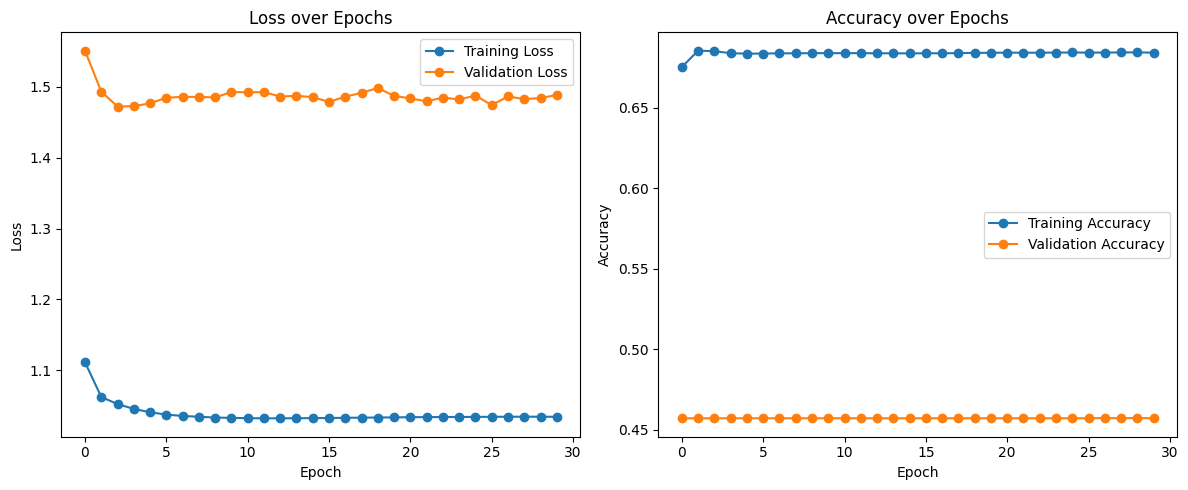

1816/1816 [==============================] - 5s 3ms/step - loss: 1.4883 - accuracy: 0.4572
Test Accuracy: 0.46
1816/1816 [==============================] - 3s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00      4854
           2       0.00      0.00      0.00     17390
           3       0.00      0.00      0.00      1951
           4       0.00      0.00      0.00      1240
           6       0.00      0.00      0.00      6078
           7       0.46      1.00      0.63     26561

    accuracy                           0.46     58094
   macro avg       0.07      0.14      0.09     58094
weighted avg       0.21      0.46      0.29     58094



c:\Users\gpu.arl\.conda\envs\2448507\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gpu.arl\.conda\envs\2448507\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gpu.arl\.conda\envs\2448507\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
import os
import numpy as np
import scipy.signal
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Path to processed EEG epochs
data_folder = "processed_epochs"

def extract_psd_features(eeg_epoch, fs):
    freqs, psd = scipy.signal.welch(eeg_epoch, fs=fs, nperseg=fs*2)
    psd = np.log1p(psd)
    return psd.flatten()

# Load features and labels
X, y = [], []

for file in os.listdir(data_folder):
    if file.endswith(".npz"):
        data = np.load(os.path.join(data_folder, file))
        eeg_epochs = data["eeg"]
        labels = data["labels"]
        fs = data["fs"]

        for i in range(eeg_epochs.shape[0]):
            # Stack PSD features from each channel horizontally
            features = np.hstack([extract_psd_features(eeg_epochs[i, ch], fs) 
                                  for ch in range(eeg_epochs.shape[1])])
            X.append(features)
            y.append(labels[i])

X, y = np.array(X), np.array(y)

# Check and replace NaN or Inf values
if np.isnan(X).any() or np.isinf(X).any():
    print("Warning: NaN or Inf detected in feature matrix! Replacing with zero.")
    X = np.nan_to_num(X)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
num_classes = len(np.unique(y))

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Use TimeSeriesSplit to generate training and test sets
tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X))
train_idx, test_idx = splits[-1]  # Use the last fold as the hold-out test set

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Create tf.data.Datasets for efficient data loading
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build a more complex model architecture
input_dim = X_train.shape[1]
model = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')  
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


epochs = 30
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset
)

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}")

# Predict and generate a classification report
y_pred_prob = model.predict(test_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)

print("Classification Report:\n", classification_report(y_test, y_pred))


LSTM WITH PSD FEATURES

In [ ]:
LSTM WITH REGULARIZATION


=== Fold 1 ===
Epoch 1/25
908/908 [==============================] - 13s 12ms/step - loss: 1.0651 - accuracy: 0.6658 - val_loss: 1.0019 - val_accuracy: 0.6896
Epoch 2/25
908/908 [==============================] - 10s 11ms/step - loss: 0.9679 - accuracy: 0.6699 - val_loss: 1.0301 - val_accuracy: 0.6715
Epoch 3/25
908/908 [==============================] - 10s 11ms/step - loss: 0.9334 - accuracy: 0.6757 - val_loss: 1.0413 - val_accuracy: 0.6493
Epoch 4/25
908/908 [==============================] - 10s 11ms/step - loss: 0.9125 - accuracy: 0.6820 - val_loss: 1.0341 - val_accuracy: 0.6744
Epoch 5/25
908/908 [==============================] - 10s 11ms/step - loss: 0.8928 - accuracy: 0.6867 - val_loss: 1.1026 - val_accuracy: 0.6580
Epoch 6/25
1816/1816 [==============================] - 5s 3ms/step
Fold 1 Accuracy: 0.6896
               precision    recall  f1-score   support

Movement time       0.00      0.00      0.00        19
Sleep stage 1       0.00      0.00      0.00      2734
Sleep 

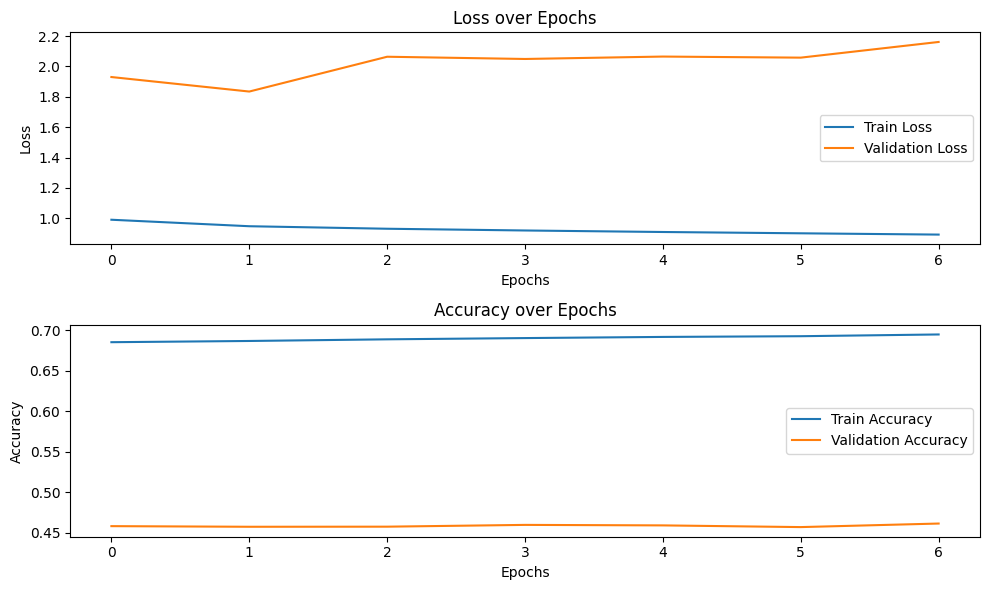

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import os
import scipy.signal

# Path to processed EEG epochs
data_folder = "processed_epochs"

def extract_psd_features(eeg_epoch, fs):
    freqs, psd = scipy.signal.welch(eeg_epoch, fs=fs, nperseg=fs * 2)
    psd = np.log1p(psd)
    return psd.flatten()

# Data loading and feature extraction
X, y = [], []
for file in os.listdir(data_folder):
    if file.endswith(".npz"):
        data = np.load(os.path.join(data_folder, file))
        eeg_epochs, labels, fs = data["eeg"], data["labels"], data["fs"]

        for i in range(eeg_epochs.shape[0]):
            features = np.array([extract_psd_features(eeg_epochs[i, ch], fs) for ch in range(eeg_epochs.shape[1])])
            X.append(features)
            y.append(labels[i])

X = np.array(X)  # (samples, channels, psd_features)
y = np.array(y)

# Handle NaNs or Infs
if np.isnan(X).any() or np.isinf(X).any():
    print("Replacing NaN/Inf with zero")
    X = np.nan_to_num(X)

# Label encoding
le = LabelEncoder()
y = le.fit_transform(y)

# Reshape for scaling (samples * channels, features)
num_samples, num_channels, num_features = X.shape
X_reshaped = X.reshape(-1, num_features)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)

# Reshape back to original shape
X = X_scaled.reshape(num_samples, num_channels, num_features)

# TensorFlow Model with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
fold = 1
history_list = []

for train_index, test_index in tscv.split(X):
    print(f"\n=== Fold {fold} ===")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Build the LSTM model
    model = models.Sequential([
        layers.Input(shape=(num_channels, num_features)),
        layers.LSTM(256, return_sequences=True),
        layers.Dropout(0.3),
        layers.LSTM(128, return_sequences=True),
        layers.Dropout(0.3),
        layers.LSTM(64),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(len(np.unique(y)), activation='softmax')
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=25,
        batch_size=64,
        callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=1
    )
    history_list.append(history)

    # Evaluate
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(f"Fold {fold} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    # ✅ Fix the classification report call to prevent ValueError
    print(classification_report(
        y_test,
        y_pred,
        target_names=le.classes_,
        labels=range(len(le.classes_)),
        zero_division=0
    ))
    fold += 1

#  Plotting Last Fold 
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.signal

# Path to processed EEG epochs
data_folder = "processed_epochs"

# PSD feature extraction
def extract_psd_features(eeg_epoch, fs):
    freqs, psd = scipy.signal.welch(eeg_epoch, fs=fs, nperseg=fs * 2)
    psd = np.log1p(psd)
    return psd.flatten()

# Load and preprocess data
X, y = [], []
for file in os.listdir(data_folder):
    if file.endswith(".npz"):
        data = np.load(os.path.join(data_folder, file))
        eeg_epochs, labels, fs = data["eeg"], data["labels"], data["fs"]
        for i in range(eeg_epochs.shape[0]):
            features = np.array([extract_psd_features(eeg_epochs[i, ch], fs) for ch in range(eeg_epochs.shape[1])])
            X.append(features)
            y.append(labels[i])

X = np.array(X)
y = np.array(y)

# Handle NaN/Inf
X = np.nan_to_num(X)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = np.array([scaler.fit_transform(sample) for sample in X_train])
X_test = np.array([scaler.transform(sample) for sample in X_test])

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# LSTM Model with 3 LSTM Layers
class EEG_LSTM_Model(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EEG_LSTM_Model, self).__init__()
        self.lstm1 = nn.LSTM(input_size, 128, batch_first=True, dropout=0.3)
        self.lstm2 = nn.LSTM(128, 64, batch_first=True, dropout=0.3)
        self.lstm3 = nn.LSTM(64, 32, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(32, 32)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = x[:, -1, :]
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = EEG_LSTM_Model(input_size=X_train.shape[2], num_classes=len(np.unique(y)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Train accuracy
    _, predicted = torch.max(output, 1)
    train_acc = (predicted == y_train_tensor).float().mean().item()
    train_accuracies.append(train_acc)

    # Test accuracy
    model.eval()
    with torch.no_grad():
        test_output = model(X_test_tensor)
        _, test_pred = torch.max(test_output, 1)
        test_acc = (test_pred == y_test_tensor).float().mean().item()
        test_accuracies.append(test_acc)

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

# Final Evaluation
model.eval()
with torch.no_grad():
    final_output = model(X_test_tensor)
    _, final_pred = torch.max(final_output, 1)
    final_pred_np = final_pred.numpy()

# Accuracy & Kappa
accuracy = accuracy_score(y_test, final_pred_np)
kappa = cohen_kappa_score(y_test, final_pred_np)
print(f"\nFinal Test Accuracy: {accuracy:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print("Classification Report:\n", classification_report(y_test, final_pred_np, target_names=le.classes_))

# Confusion Matrix Plot
cm = confusion_matrix(y_test, final_pred_np)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Accuracy Plot
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy (3 LSTM Layers)')
plt.legend()
plt.grid()
plt.show()


In [16]:
import numpy as np
import pywt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Path to processed EEG epochs
data_folder = "processed_epochs"

# Function to compute DWT features
def extract_dwt_features(eeg_epoch, wavelet='db4', level=1):
    coeffs = pywt.wavedec(eeg_epoch, wavelet, level=level)
    features = np.concatenate([c.flatten() for c in coeffs])  # Flatten all coefficients
    return features

X = []
y = []

for file in os.listdir(data_folder):
    if file.endswith(".npz"):
        data = np.load(os.path.join(data_folder, file))
        eeg_epochs = data["eeg"]  
        labels = data["labels"]

        # Extract DWT features for each epoch
        for i in range(eeg_epochs.shape[0]):
            features = np.array([extract_dwt_features(eeg_epochs[i, ch]) for ch in range(eeg_epochs.shape[1])])
            X.append(features)
            y.append(labels[i])

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Handle NaN/Inf values
if np.isnan(X).any() or np.isinf(X).any():
    print("Warning: NaN or Inf detected in feature matrix! Replacing with zero.")
    X = np.nan_to_num(X)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = np.array([scaler.fit_transform(sample) for sample in X_train])
X_test = np.array([scaler.transform(sample) for sample in X_test])

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Set the number of CPU threads (limit to 30)
torch.set_num_threads(30)

# Check if GPU is available, and move the model and data to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define LSTM Model with Regularization
class EEGModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EEGModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, 64, batch_first=True, dropout=0.3)
        self.lstm2 = nn.LSTM(64, 32, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(32, 32)
        self.fc2 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # Take the output of the last LSTM time step
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = EEGModel(input_size=X_train.shape[2], num_classes=len(np.unique(y)))
model.to(device)  # Move the model to GPU (if available)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 30
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Move data to device (GPU or CPU)
    X_train_tensor = X_train_tensor.to(device)
    y_train_tensor = y_train_tensor.to(device)
    
    # Forward pass
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Calculate train accuracy
    _, predicted = torch.max(output, 1)
    train_accuracy = (predicted == y_train_tensor).float().mean().item()
    train_accuracies.append(train_accuracy)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        X_test_tensor = X_test_tensor.to(device)
        y_test_tensor = y_test_tensor.to(device)
        test_output = model(X_test_tensor)
        _, test_predicted = torch.max(test_output, 1)
        test_accuracy = (test_predicted == y_test_tensor).float().mean().item()
        test_accuracies.append(test_accuracy)
    
    # Print epoch results
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Final evaluation
model.eval()
with torch.no_grad():
    final_test_output = model(X_test_tensor.to(device))
    _, final_test_predicted = torch.max(final_test_output, 1)
    accuracy = accuracy_score(y_test, final_test_predicted.cpu().numpy())
    print(f"Final Test Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, final_test_predicted.cpu().numpy()))

# Plot training vs validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM with DWT Features: Training vs. Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

c:\Users\gpu.arl\.conda\envs\2448507\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 21.54 GiB. GPU 0 has a total capacity of 47.99 GiB of which 0 bytes is free. Of the allocated memory 12.90 GiB is allocated by PyTorch, and 22.58 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import numpy as np
import pywt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Path to processed EEG epochs
data_folder = "processed_epochs"

# Function to compute DWT features
def extract_dwt_features(eeg_epoch, wavelet='db4', level=1):
    coeffs = pywt.wavedec(eeg_epoch, wavelet, level=level)
    features = np.concatenate([c.flatten() for c in coeffs])  # Flatten all coefficients
    return features

X = []
y = []

for file in os.listdir(data_folder):
    if file.endswith(".npz"):
        data = np.load(os.path.join(data_folder, file))
        eeg_epochs = data["eeg"]  
        labels = data["labels"]

        # Extract DWT features for each epoch
        for i in range(eeg_epochs.shape[0]):
            features = np.array([extract_dwt_features(eeg_epochs[i, ch]) for ch in range(eeg_epochs.shape[1])])
            X.append(features)
            y.append(labels[i])

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Handle NaN/Inf values
if np.isnan(X).any() or np.isinf(X).any():
    print("Warning: NaN or Inf detected in feature matrix! Replacing with zero.")
    X = np.nan_to_num(X)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = np.array([scaler.fit_transform(sample) for sample in X_train])
X_test = np.array([scaler.transform(sample) for sample in X_test])

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Set the number of CPU threads (limit to 30)
torch.set_num_threads(30)

# Check if GPU is available, and move the model and data to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define LSTM Model with Regularization
class EEGModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EEGModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, 64, batch_first=True, dropout=0.3)
        self.lstm2 = nn.LSTM(64, 32, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(32, 32)
        self.fc2 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # Take the output of the last LSTM time step
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = EEGModel(input_size=X_train.shape[2], num_classes=len(np.unique(y)))
model.to(device)  # Move the model to GPU (if available)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 30
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Move data to device (GPU or CPU)
    X_train_tensor = X_train_tensor.to(device)
    y_train_tensor = y_train_tensor.to(device)
    
    # Forward pass
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Calculate train accuracy
    _, predicted = torch.max(output, 1)
    train_accuracy = (predicted == y_train_tensor).float().mean().item()
    train_accuracies.append(train_accuracy)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        X_test_tensor = X_test_tensor.to(device)
        y_test_tensor = y_test_tensor.to(device)
        test_output = model(X_test_tensor)
        _, test_predicted = torch.max(test_output, 1)
        test_accuracy = (test_predicted == y_test_tensor).float().mean().item()
        test_accuracies.append(test_accuracy)
    
    # Print epoch results
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Final evaluation
model.eval()
with torch.no_grad():
    final_test_output = model(X_test_tensor.to(device))
    _, final_test_predicted = torch.max(final_test_output, 1)
    accuracy = accuracy_score(y_test, final_test_predicted.cpu().numpy())
    print(f"Final Test Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, final_test_predicted.cpu().numpy()))

# Plot training vs validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM with DWT Features: Training vs. Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, confusion_matrix

# Path to processed EEG epochs
data_folder = "processed_epochs"

# Statistical feature extraction per channel
def extract_statistical_features(eeg_epoch):
    features = []
    features.append(np.mean(eeg_epoch))        # Mean
    features.append(np.std(eeg_epoch))         # Standard Deviation
    features.append(np.var(eeg_epoch))         # Variance
    features.append(np.median(eeg_epoch))      # Median
    features.append(np.max(eeg_epoch))         # Max
    features.append(np.min(eeg_epoch))         # Min
    features.append(np.ptp(eeg_epoch))         # Peak-to-Peak
    features.append(np.percentile(eeg_epoch, 25))  # 25th Percentile
    features.append(np.percentile(eeg_epoch, 75))  # 75th Percentile
    return features

# Load and extract statistical features
X, y = [], []
for file in os.listdir(data_folder):
    if file.endswith(".npz"):
        data = np.load(os.path.join(data_folder, file))
        eeg_epochs, labels = data["eeg"], data["labels"]
        for i in range(eeg_epochs.shape[0]):
            epoch_features = []
            for ch in range(eeg_epochs.shape[1]):
                ch_features = extract_statistical_features(eeg_epochs[i, ch])
                epoch_features.extend(ch_features)  # Flatten channel features
            X.append(epoch_features)
            y.append(labels[i])

X = np.array(X)
y = np.array(y)

# Replace NaNs/Infs
X = np.nan_to_num(X)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVM Classifier (RBF kernel)
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predictions
y_pred = svm_model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print(f"\nSVM Final Test Accuracy: {accuracy:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Confusion Matrix')
plt.show()

# Covariance Matrix of the Features
cov_matrix = np.cov(X_train, rowvar=False)  # Covariance across features
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, cmap='viridis')
plt.title('Covariance Matrix of Extracted Statistical Features')
plt.xlabel('Feature Index')
plt.ylabel('Feature Index')
plt.show()


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, confusion_matrix

# Path to processed EEG epochs
data_folder = "processed_epochs"

# Statistical feature extraction per channel
def extract_statistical_features(eeg_epoch):
    features = []
    features.append(np.mean(eeg_epoch))        # Mean
    features.append(np.std(eeg_epoch))         # Standard Deviation
    features.append(np.var(eeg_epoch))         # Variance
    features.append(np.median(eeg_epoch))      # Median
    features.append(np.max(eeg_epoch))         # Max
    features.append(np.min(eeg_epoch))         # Min
    features.append(np.ptp(eeg_epoch))         # Peak-to-Peak
    features.append(np.percentile(eeg_epoch, 25))  # 25th Percentile
    features.append(np.percentile(eeg_epoch, 75))  # 75th Percentile
    return features

# Load and extract statistical features
X, y = [], []
for file in os.listdir(data_folder):
    if file.endswith(".npz"):
        data = np.load(os.path.join(data_folder, file))
        eeg_epochs, labels = data["eeg"], data["labels"]
        for i in range(eeg_epochs.shape[0]):
            epoch_features = []
            for ch in range(eeg_epochs.shape[1]):
                ch_features = extract_statistical_features(eeg_epochs[i, ch])
                epoch_features.extend(ch_features)  # Flatten channel features
            X.append(epoch_features)
            y.append(labels[i])

X = np.array(X)
y = np.array(y)

# Replace NaNs/Infs
X = np.nan_to_num(X)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Feature scaling (optional for RF but good practice)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print(f"\nRandom Forest Final Test Accuracy: {accuracy:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Covariance Matrix of the Features
cov_matrix = np.cov(X_train, rowvar=False)  # Covariance across features
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, cmap='viridis')
plt.title('Covariance Matrix of Extracted Statistical Features (Random Forest)')
plt.xlabel('Feature Index')
plt.ylabel('Feature Index')
plt.show()
